# Demo the Arbitrageur Agent Logic

This notebook:

1. Fetches the latest crvusd contract data into Python objects using `crvusdsim`.
2. Fetches prices and `ExternalMarket`s from the `baseline` scenario.
3. Instantiates an Arbitrageur agent.
4. Checks if there are profitable arbitrages and performs them.

In [1]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from crvusdsim.pool import get
from src.agents.arbitrageur import Arbitrageur
from src.sim.scenario import Scenario
from src.utils.poolgraph import PoolGraph
from src.configs import SYMBOL_TO_ADDRESS
from src.configs.tokens import *
from src.modules import ExternalMarket


%load_ext autoreload
%autoreload 2

In [2]:
arbitrageur = Arbitrageur()

ETH_POOL = "weth"
sim_market = get(ETH_POOL, bands_data="controller")

pool = sim_market.pool
stableswap_pools = sim_market.stableswap_pools

In [3]:
# Verify snapshot context works on StableSwap pools from crvusdsim
i, j = 1, 0

stableswap_pool = stableswap_pools[2]
high = stableswap_pool.get_max_trade_size(i, j)
prev_bals = stableswap_pool.balances.copy()

print("Pre Trade")
print("Balances", prev_bals)
print("High", high)
print("Allowance", stableswap_pool.coins[0].balanceOf[stableswap_pool.address])
print()

with stableswap_pool.use_snapshot_context():
    amt_out = stableswap_pool.trade(i, j, high)
    swap_bals = stableswap_pool.balances.copy()
    print("Post Trade")
    print("Amount out", amt_out)
    print("Balances", swap_bals)
    print("Allowance", stableswap_pool.coins[0].balanceOf[stableswap_pool.address])
    print()

new_bals = stableswap_pool.balances.copy()
print("After reversing snapshot context")
print("Balances", new_bals)
print("Allowance", stableswap_pool.coins[0].balanceOf[stableswap_pool.address])

assert prev_bals == new_bals, (prev_bals, new_bals)
assert swap_bals != new_bals

Pre Trade
Balances [10008658850325, 25873939907962300163632541]
High 12842547157360454826337406
Allowance 10008658850325

Post Trade
Amount out (12842547157360454826337406, 9907581404595, 990857226182175000850)
Balances [100582017117, 38716487065322754989969947]
Allowance 101077445730

After reversing snapshot context
Balances [10008658850325, 25873939907962300163632541]
Allowance 10008658850325


In [4]:
# Verify snapshot context works on LLAMMA pools
i, j = 0, 1
high = pool.get_max_trade_size(i, j)

prev_bals = (sum(pool.bands_x.values()), sum(pool.bands_y.values()))

print("Pre Trade")
print("Balances", prev_bals)
print("High", high)
print("Stablecoin", pool.BORROWED_TOKEN.balanceOf[pool.address])
print("Collateral", pool.COLLATERAL_TOKEN.balanceOf[pool.address])
print()

with pool.use_snapshot_context():
    amt_in, amt_out, _ = pool.trade(i, j, high)
    swap_bals = (sum(pool.bands_x.values()), sum(pool.bands_y.values()))
    print("Amount in", high)
    print("Amount out", amt_out)
    print()
    print("Post Trade")
    print("Balances", swap_bals)
    print("Stablecoin", pool.BORROWED_TOKEN.balanceOf[pool.address])
    print("Collateral", pool.COLLATERAL_TOKEN.balanceOf[pool.address])
    print()

new_bals = (sum(pool.bands_x.values()), sum(pool.bands_y.values()))
print("After reversing snapshot context")
print("Balances", new_bals)
print("Stablecoin", pool.BORROWED_TOKEN.balanceOf[pool.address])
print("Collateral", pool.COLLATERAL_TOKEN.balanceOf[pool.address])

assert prev_bals == new_bals, (prev_bals, new_bals)
assert swap_bals != new_bals

Pre Trade
Balances (0, 15971445880068407183360)
High 40119568578427971526152911
Stablecoin 0
Collateral 15971445880068407183360

Amount in 40119568578427971526152911
Amount out 12702926360139514396671

Post Trade
Balances (40119568578427971525912220, 3268519519928892786689)
Stablecoin 40119568578427971526152911
Collateral 3268519519928892786689

After reversing snapshot context
Balances (0, 15971445880068407183360)
Stablecoin 0
Collateral 15971445880068407183360


In [5]:
# Generate markets and prices
config = "../src/configs/scenarios/baseline.json"
scenario = Scenario(config)
markets = scenario.generate_markets()
prices = scenario.generate_pricepaths("../" + scenario.price_config)
scenario.update_market_prices(prices[-1])

[INFO][16:50:04][root]-567577: Reading price config from ../src/configs/scenarios/baseline.json.
[INFO][16:50:04][root]-567577: Fetching 1inch quotes.


[INFO][16:50:10][root]-567577: We have 462240 quotes.
[INFO][16:50:10][root]-567577: Fitting external markets against 1inch quotes.
[INFO][16:50:10][root]-567577: Reading price config from ../src/configs/prices/1h_1696108632_1701289032.json.


In [6]:
# Create a list of all stableswap pools, LLAMMAs, and External Markets.
markets_lst = list(markets.values())
pools = stableswap_pools + [pool] + markets_lst
print(
    f"There are {len(pools)} total pools:\nStableSwap: {len(stableswap_pools)}\nLLAMMA: 1\nExternal Markets: {len(markets_lst)}"
)

There are 20 total pools:
StableSwap: 4
LLAMMA: 1
External Markets: 15


In [7]:
n = 3
graph = PoolGraph(pools)
cycles = graph.find_cycles(n=n)
cycles

[INFO][16:50:10][root]-567577: Found 20 valid cycles of length 3.


[Cycle(Trades: [Swap(pool=Curve.fi Factory Plain Pool: crvUSD/TUSD, in=TUSD, out=Curve.Fi USD Stablecoin (crvUSD), amt=None), Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDP, in=Curve.Fi USD Stablecoin (crvUSD), out=USDP, amt=None), Swap(pool=External Market (TUSD, USDP), in=Pax Dollar, out=TrueUSD, amt=None)], Expected Profit: None),
 Cycle(Trades: [Swap(pool=Curve.fi Factory Plain Pool: crvUSD/TUSD, in=TUSD, out=Curve.Fi USD Stablecoin (crvUSD), amt=None), Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDC, in=Curve.Fi USD Stablecoin (crvUSD), out=USDC, amt=None), Swap(pool=External Market (TUSD, USDC), in=USD Coin, out=TrueUSD, amt=None)], Expected Profit: None),
 Cycle(Trades: [Swap(pool=Curve.fi Factory Plain Pool: crvUSD/TUSD, in=TUSD, out=Curve.Fi USD Stablecoin (crvUSD), amt=None), Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDT, in=Curve.Fi USD Stablecoin (crvUSD), out=USDT, amt=None), Swap(pool=External Market (TUSD, USDT), in=Tether USD, out=TrueUSD, amt=None)], Expect

In [8]:
df = pd.DataFrame(
    columns=["amt_optimize", "amt_linspace", "profit_optimize", "profit_linspace"]
)

for i, cycle in enumerate(cycles):
    try:
        # This is orders of magnitude slower than `optimize`
        trade = cycle.trades[0]
        high = trade.pool.get_max_trade_size(trade.i, trade.j)
        amts = np.linspace(0, high, 1000)
        amts = [int(amt) for amt in amts]
        profits = [cycle.populate(amt) for amt in amts]

        best_amt_linspace = int(amts[np.argmax(profits)])
        best_profit_linspace = int(max(profits))

        cycle.optimize()

        df.loc[i] = [
            cycle.trades[0].amt,
            best_amt_linspace,
            cycle.expected_profit,
            best_profit_linspace,
        ]

    except Exception as e:
        logging.error(f"Cycle {i} failed to optimize: {e}")

df["profit_linspace"] = df["profit_linspace"].astype(float)
df["profit_optimize"] = df["profit_optimize"].astype(float)
df = df.round(3)
df

,amt_optimize,amt_linspace,profit_optimize,profit_linspace
0,774.0,0.0,-0.000,0.0
1,209750873487598770192384,248794615731133624614912,187.439,172.0
2,1039400679781033324838912,0,-2473.007,0.0
3,1803309387791062299312128,1851555719178015687573504,84321.576,85204.0
4,95151927773565097607168,56063479498935109681152,38.555,22.0
5,655926218805288380661760,634218111831703413587968,692.121,689.0
6,442207477476863709806592,217245983058373562597376,54.515,133.0
7,825212518026893305315328,830440290077976347803648,55610.340,56842.0
8,251.0,0.0,-0.000,0.0
9,335.0,0.0,-0.000,0.0


[WARNING][16:50:23][root]-567577: LLAMMA amt_in 1 != in_amount_done 0.


Best amount linspace: 1851555719178015687573504
Best profit linspace: 85204.68462782541
Best amount optimize: 1803309387791062299312128
Best profit optimize: 84321.57593288147


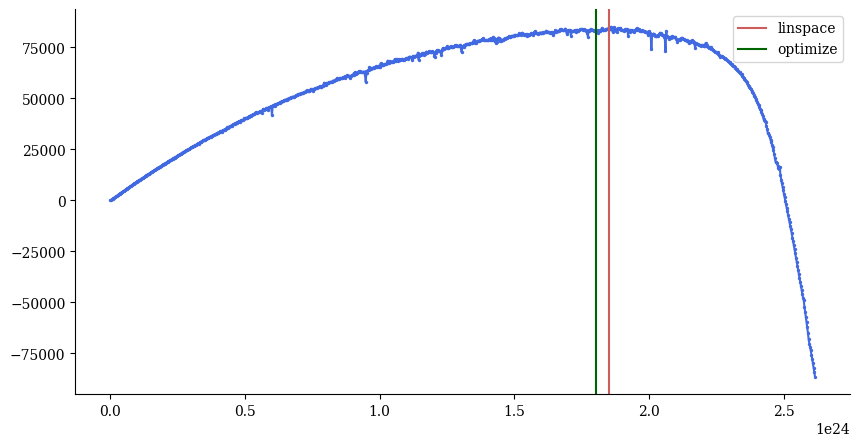

In [9]:
# TODO this curve is probably not smooth because:
# 1. The decimals are not being treated correctly between trades
# 2. The state of each pool is not being snapshot correctly (i.e. it's changing)

i = 3
cycle = cycles[i]

trade = cycle.trades[0]
high = trade.pool.get_max_trade_size(trade.i, trade.j)
amts = np.linspace(1, high, 1000)
amts = [int(amt) for amt in amts]
profits = [cycle.populate(amt) for amt in amts]

best_amt_linspace = amts[np.argmax(profits)]
best_profit_linspace = max(profits)

# compare
cycle.optimize()
best_amt_optimize = cycle.trades[0].amt
best_profit_optimize = cycle.expected_profit

f, ax = plt.subplots(figsize=(10, 5))
ax.scatter(amts, profits, color="royalblue", s=2)
ax.plot(amts, profits, color="royalblue")
ax.axvline(best_amt_linspace, color="indianred", label="linspace")
ax.axvline(best_amt_optimize, color="darkgreen", label="optimize")

ax.legend()

print(f"Best amount linspace: {best_amt_linspace}")
print(f"Best profit linspace: {best_profit_linspace}")
print(f"Best amount optimize: {best_amt_optimize}")
print(f"Best profit optimize: {best_profit_optimize}")

# Analyzing arbitrages

In [10]:
best = arbitrageur.find_best_arbitrage(cycles)
best

Cycle(Trades: [Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDC, in=USDC, out=Curve.Fi USD Stablecoin (crvUSD), amt=2170987683691), Swap(pool=Curve.fi Stablecoin WETH, in=crvUSD, out=WETH, amt=2175352234146137512897804), Swap(pool=External Market (USDC, WETH), in=Wrapped Ether, out=USD Coin, amt=1060567024683191920725)], Expected Profit: 96536.282693)

In [11]:
# get the trades in the cycle
# the price of pool 1 * price of pool 2 should approach pool 3
def get_prices(cycle):
    prices = []
    for trade in best.trades:
        price = trade.pool.price(trade.i, trade.j)
        if not isinstance(trade.pool, ExternalMarket):
            price /= 1e18
        prices.append(price)
    return prices

prices = get_prices(best)

print(f"Pre Trade prices: {prices}")
print(f"External Market price: {prices[2]}")
print(f"Curve pool prices: {prices[0] * prices[1]}")
print()

best.execute()
prices = get_prices(best)

print(f"Post Trade prices: {prices}")
print(f"External Market price: {prices[2]}")
print(f"Curve pool prices: {prices[0] * prices[1]}")

[INFO][16:50:25][root]-567577: Executing trade Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDC, in=USDC, out=Curve.Fi USD Stablecoin (crvUSD), amt=2170987683691).
[INFO][16:50:25][root]-567577: Executing trade Swap(pool=Curve.fi Stablecoin WETH, in=crvUSD, out=WETH, amt=2175352234146137512897804).
[INFO][16:50:25][root]-567577: Executing trade Swap(pool=External Market (USDC, WETH), in=Wrapped Ether, out=USD Coin, amt=1060567024683191920725).


Pre Trade prices: [0.9972815765260359, 1944.6148765912665, 2138.0677672286333]
External Market price: 2138.0677672286333
Curve pool prices: 1939.328589862921

Post Trade prices: [0.9984094237929201, 2123.3962086507872, 2138.0677672286333]
External Market price: 2138.0677672286333
Curve pool prices: 2120.0187851631035
